In [1]:
# Planning Steps for this project:
# 1 import all necessary libraries and functions
# 2 read in data
# 3 feature eng: narrow down columns
# 4 feature eng: create new columns
# 5 set numerical_columns and categorical_columns
# 6 train test split X and y
# 7 define pipeline with preprocessors and XGBRegressor model
# 8 fit the model and make predictions
# 9 make improvements and then use all training data
# 10 submit (woohoo)

In [2]:
# 1.1 import general libraries

In [3]:
import numpy as np
import pandas as pd
import sklearn as sk
import xgboost as xg
import joblib
import seaborn as sns

In [4]:
# 1.2 import specific libraries

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# pipeline / preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest

# xgboost
from xgboost import XGBRegressor

# feature engineering
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder

In [6]:
# 2.1 read in the data

In [7]:
train_df = pd.read_csv(r"C:\Users\miria\OneDrive\Documents\DS Learn\practice datasets\kagglehousingpricesdata\train.csv")
test_df = pd.read_csv(r"C:\Users\miria\OneDrive\Documents\DS Learn\practice datasets\kagglehousingpricesdata\test.csv")

In [8]:
# 2.2 handle NaN/missing values

In [9]:
train_df.interpolate(method='linear', inplace = True)
test_df.interpolate(method='linear', inplace = True)

C:\Users\miria\AppData\Local\Temp\ipykernel_16488\2809896621.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  train_df.interpolate(method='linear', inplace = True)
C:\Users\miria\AppData\Local\Temp\ipykernel_16488\2809896621.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  test_df.interpolate(method='linear', inplace = True)


In [10]:
# 3.1 first determine discrete_features

In [11]:
X = train_df.copy()
y = X.pop("SalePrice")

# label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# ensure that all discrete features are of integer dtype
discrete_features = X.dtypes == int

In [12]:
# 3.2 use discrete_features to make a list of mi scores

In [13]:
mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X.columns).sort_values(ascending = False)

# print out all values
pd.set_option('display.max_rows', 500)
mi_scores

OverallQual      0.555143
Neighborhood     0.505219
GrLivArea        0.480868
GarageCars       0.377972
GarageArea       0.369521
TotalBsmtSF      0.368922
YearBuilt        0.363837
BsmtQual         0.327259
ExterQual        0.326743
KitchenQual      0.319024
1stFlrSF         0.311651
MSSubClass       0.278243
FullBath         0.260361
GarageFinish     0.250419
YearRemodAdd     0.246225
GarageYrBlt      0.236048
TotRmsAbvGrd     0.214008
GarageType       0.201417
FireplaceQu      0.200410
2ndFlrSF         0.192266
Foundation       0.191707
LotFrontage      0.184437
Fireplaces       0.167164
HeatingQC        0.163763
LotArea          0.159784
Exterior2nd      0.157527
BsmtFinType1     0.151329
BsmtFinSF1       0.150722
OpenPorchSF      0.141285
Exterior1st      0.126721
OverallCond      0.124408
BsmtUnfSF        0.120075
MSZoning         0.117913
WoodDeckSF       0.111826
MasVnrType       0.097987
MasVnrArea       0.092782
HouseStyle       0.085420
LotShape         0.080615
HalfBath    

In [14]:
# 3.3 investigate features that may have an interaction with more important features

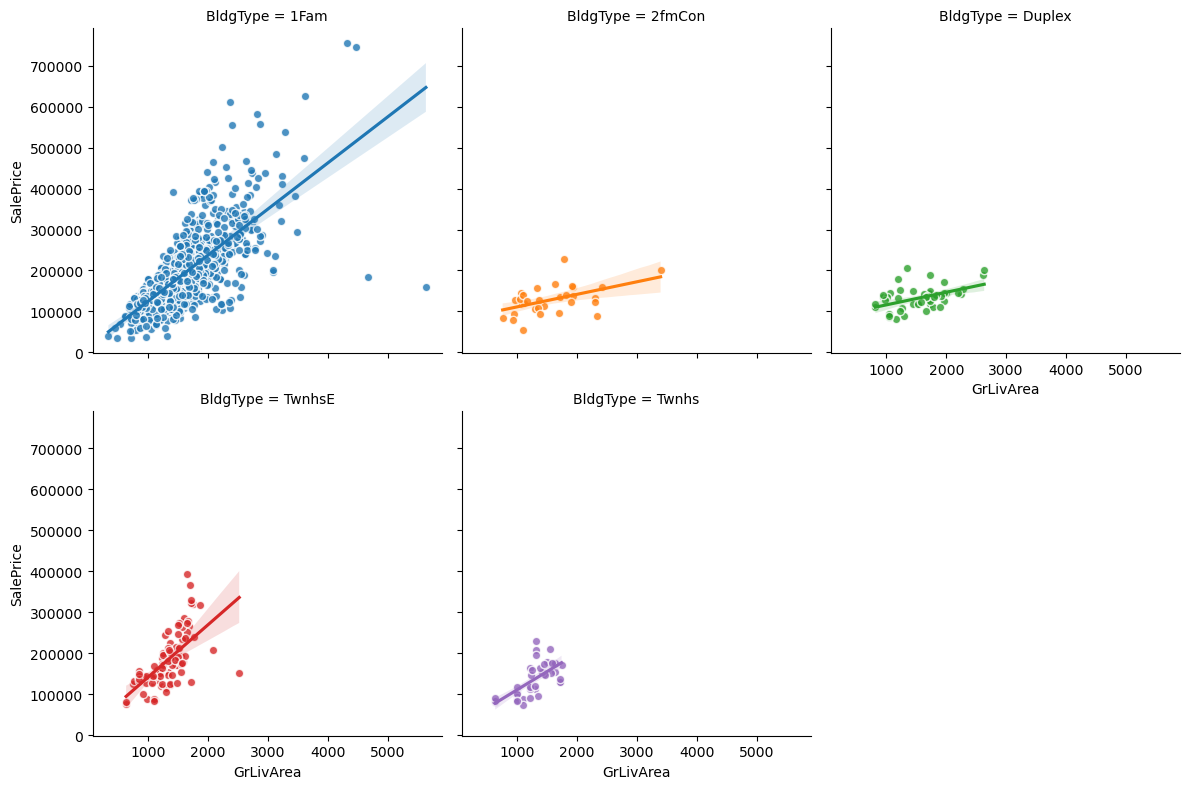

In [15]:
# investigate interaction between BldgType and GrLivArea

sns.lmplot(
    x = "GrLivArea", y = "SalePrice", hue = "BldgType", col = "BldgType", data = train_df, scatter_kws = {"edgecolor": 'w'}, col_wrap = 3, height = 4)

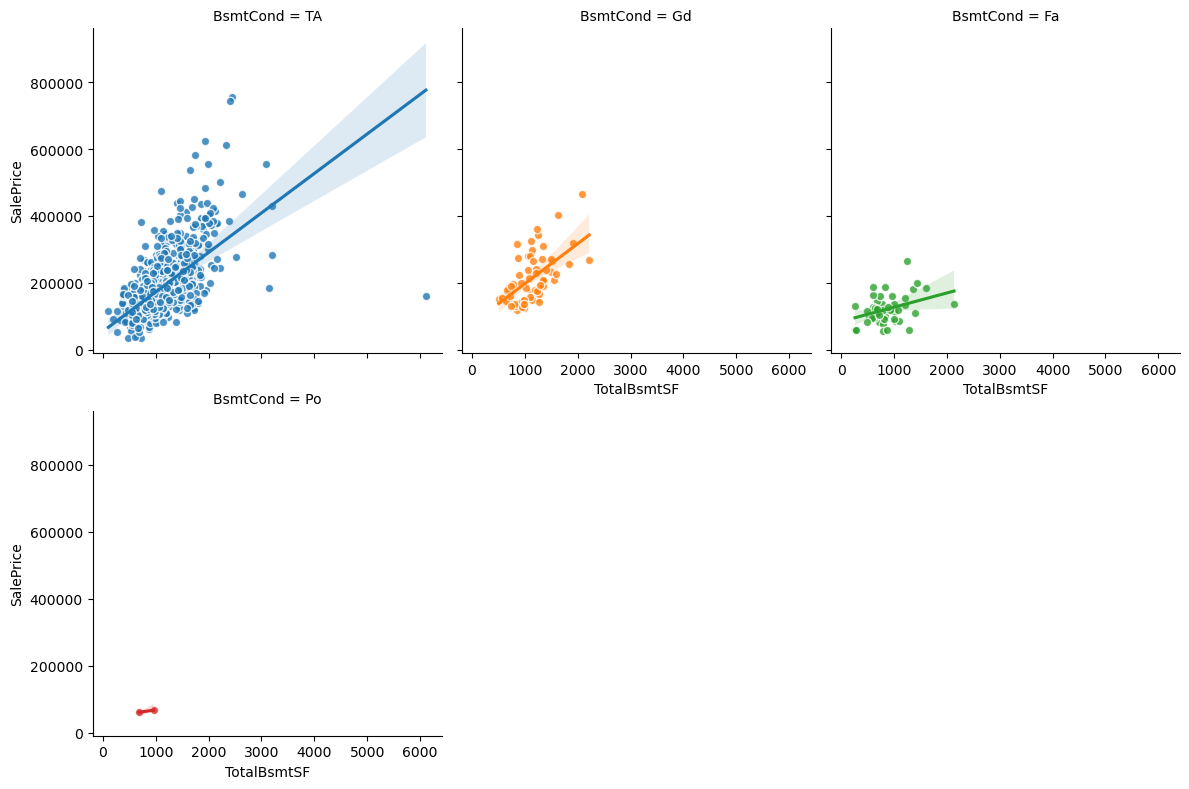

In [16]:
# investigate interaction between TotalBsmtSF and BsmtCond

sns.lmplot(x = "TotalBsmtSF", y = "SalePrice", hue = "BsmtCond", col = "BsmtCond", data = train_df, scatter_kws = {"edgecolor": 'w'}, col_wrap = 3, height = 4)

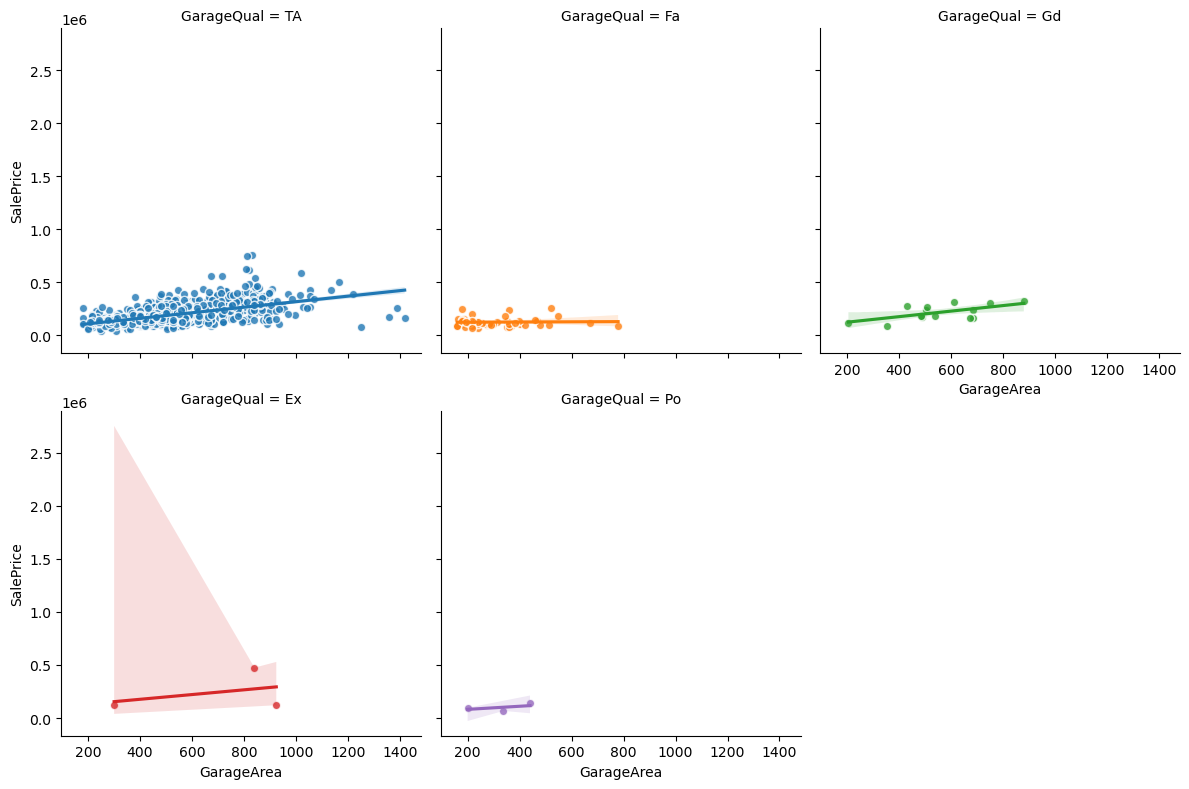

In [17]:
# investigating interaction between GarageArea and GarageQual

sns.lmplot(x = "GarageArea", y = "SalePrice", hue = "GarageQual", col = "GarageQual", data = train_df, scatter_kws = {"edgecolor": 'w'}, col_wrap = 3, height = 4)

In [18]:
# 4.1 create ratio features

In [19]:
# GrAreaRmsRatio: Ratio of Area to Rooms above ground level
train_df['GrAreaRmsRatio'] = train_df.GrLivArea / train_df.TotRmsAbvGrd 
test_df['GrAreaRmsRatio'] = test_df.GrLivArea / test_df.TotRmsAbvGrd

In [20]:
# 4.2 clustering with k-means

In [21]:
# train_df: scaling and creating cluster labels
X = train_df.copy()

cluster_features = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea']

X[cluster_features] = X[cluster_features].astype(float)

X_scaled = X.loc[:, cluster_features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

kmeans = KMeans(n_clusters = 10, n_init = 10, random_state = 0)
X["Cluster"] = kmeans.fit_predict(X_scaled)

# train_df: adding cluster-distance features to dataset
X_cd = kmeans.fit_transform(X_scaled)
X_cd = pd.DataFrame(X_cd, columns = [f"Centroid_{i}" for i in range(X_cd.shape[1])])
train_df = X.join(X_cd)

C:\Users\miria\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\miria\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [22]:
# test_df: scaling and creating cluster labels
X = test_df.copy()

cluster_features = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea']

X[cluster_features].interpolate(method='linear', inplace = True)
X[cluster_features] = X[cluster_features].astype(float)

X_scaled = X.loc[:, cluster_features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

kmeans = KMeans(n_clusters = 10, n_init = 10, random_state = 0)
X["Cluster"] = kmeans.fit_predict(X_scaled)

# test_df: adding cluster-distance features to dataset
X_cd = kmeans.fit_transform(X_scaled)
X_cd = pd.DataFrame(X_cd, columns = [f"Centroid_{i}" for i in range(X_cd.shape[1])])
test_df = X.join(X_cd)

C:\Users\miria\AppData\Local\Temp\ipykernel_16488\612678123.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cluster_features].interpolate(method='linear', inplace = True)
C:\Users\miria\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\miria\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [23]:
# 4.3.1 principal component analysis - applying pca and extracting the loadings

pca_features = ['GrLivArea', 'TotalBsmtSF', 'GarageArea', '1stFlrSF']

X = train_df.copy()
y = X.pop('SalePrice')
X = X.loc[:, pca_features]

# standardize X
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

# create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(X_pca, columns = component_names)

# extract loadings
loadings = pd.DataFrame(pca.components_.T, columns = component_names, index = X.columns)
loadings

,PC1,PC2,PC3,PC4
GrLivArea,0.460735,0.471645,0.733604,-0.164619
TotalBsmtSF,0.530678,-0.511261,-0.152384,-0.658614
GarageArea,0.448891,0.602149,-0.658588,0.046642
1stFlrSF,0.551906,-0.391892,0.069764,0.732771


In [24]:
# 4.3.2 principal component analysis - using the loadings to create new features

# PC3: GrLivArea (+), GarageArea (-)
train_df['GarageToGround'] = train_df.GarageArea / train_df.GrLivArea
test_df['GarageToGround'] = test_df.GarageArea / test_df.GrLivArea

# PC4: TotalBsmtSF (-), 1stFlrSF (+)
train_df['BsmtToFlr'] = train_df['TotalBsmtSF'] / train_df['1stFlrSF']
test_df['BsmtToFlr'] = test_df['TotalBsmtSF'] / test_df['1stFlrSF']

In [25]:
# 5.1 determine numerical_columns and categorical_columns

In [26]:
numerical_columns = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'YearBuilt', '1stFlrSF', 'MSSubClass', 'FullBath', 'YearRemodAdd', 'TotRmsAbvGrd', '2ndFlrSF', 'LotArea', 'OverallCond', 'GrAreaRmsRatio', 'GarageToGround', 'BsmtToFlr', 'BsmtFinSF1']
categorical_columns = ['Neighborhood', 'KitchenQual', 'ExterQual', 'BsmtQual', 'GarageFinish', 'FireplaceQu', 'GarageType', 'Foundation', 'HeatingQC', 'Exterior2nd', 'Exterior1st', 'BldgType', 'BsmtCond', 'Cluster', 'BsmtFinType1']
features = numerical_columns + categorical_columns

In [27]:
# 6.1 set X and y

In [28]:
X = train_df[features]
y = train_df['SalePrice']

In [29]:
# 6.2 train test split X and y
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [30]:
# 7.1 set preprocessor for numerical data

In [31]:
numerical_transformer = SimpleImputer(strategy = 'constant').set_output(transform = "pandas")

In [32]:
# 7.2 set preprocessor for categorical data

In [33]:
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
]).set_output(transform = "pandas")

In [34]:
# 7.3 bundle the preprocessors together

In [35]:
preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer, numerical_columns), 
    ('cat', categorical_transformer, categorical_columns)
]).set_output(transform = "pandas")

In [36]:
# 7.4 use preprocessor on training data

In [37]:
encoder = preprocessor.fit(train_X)
train_X = encoder.transform(train_X)
val_X = encoder.transform(val_X)

In [38]:
# 8.1 set XGBRegressor model

In [39]:
my_model = XGBRegressor(n_estimators = 500, 
                        learning_rate = 0.05, 
                        random_state = 0,
                        early_stopping_rounds = 10, 
                        enable_categorical = True
                       )

In [40]:
# 8.2 fit the model

In [41]:
my_model.fit(X = train_X,
             y = train_y,
             eval_set = [(val_X, val_y)])

[0]	validation_0-rmse:77889.73115
[1]	validation_0-rmse:74644.44445
[2]	validation_0-rmse:71572.94745
[3]	validation_0-rmse:68888.65332
[4]	validation_0-rmse:66340.53166
[5]	validation_0-rmse:63866.57117
[6]	validation_0-rmse:61705.57523
[7]	validation_0-rmse:59631.16701
[8]	validation_0-rmse:57749.21095
[9]	validation_0-rmse:55888.68085
[10]	validation_0-rmse:54224.50786
[11]	validation_0-rmse:52589.93325
[12]	validation_0-rmse:51085.23359
[13]	validation_0-rmse:49622.66828
[14]	validation_0-rmse:48068.33902
[15]	validation_0-rmse:46741.48879
[16]	validation_0-rmse:45375.27266
[17]	validation_0-rmse:44222.80848
[18]	validation_0-rmse:43001.19786
[19]	validation_0-rmse:41940.20963
[20]	validation_0-rmse:40859.79240
[21]	validation_0-rmse:39991.26631
[22]	validation_0-rmse:39135.94869
[23]	validation_0-rmse:38339.04442
[24]	validation_0-rmse:37624.00440
[25]	validation_0-rmse:37028.77397
[26]	validation_0-rmse:36363.83181
[27]	validation_0-rmse:35699.51421
[28]	validation_0-rmse:35120.7

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [42]:
# 8.3 make predictions using the model

In [43]:
predictions = my_model.predict(val_X)

In [44]:
# 8.4 get mean absolute error

In [45]:
initial_mae = mean_absolute_error(predictions, val_y)
print(initial_mae)

15909.266866438356


In [46]:
# 9.1 use preprocessor on all training data

In [47]:
all_encoder = preprocessor.fit(X)
X = all_encoder.transform(X)

# get rid of columns in training data that aren't present in test data
X = X.drop(['cat__Exterior2nd_Other', 'cat__Exterior1st_ImStucc', 'cat__Exterior1st_Stone'], axis = 1)

In [48]:
# 9.2 fit the model on all training data

In [49]:
my_model.fit(X = X,
             y = y,
             eval_set = [(X, y)])

[0]	validation_0-rmse:76088.70437
[1]	validation_0-rmse:72941.57362
[2]	validation_0-rmse:69960.43696
[3]	validation_0-rmse:67124.94473
[4]	validation_0-rmse:64439.50140
[5]	validation_0-rmse:61872.00265
[6]	validation_0-rmse:59442.21809
[7]	validation_0-rmse:57116.77786
[8]	validation_0-rmse:54925.80757
[9]	validation_0-rmse:52832.37703
[10]	validation_0-rmse:50818.03411
[11]	validation_0-rmse:48913.21141
[12]	validation_0-rmse:47045.96623
[13]	validation_0-rmse:45304.32486
[14]	validation_0-rmse:43621.07125
[15]	validation_0-rmse:42056.00692
[16]	validation_0-rmse:40503.09238
[17]	validation_0-rmse:39083.00687
[18]	validation_0-rmse:37725.94469
[19]	validation_0-rmse:36401.42004
[20]	validation_0-rmse:35128.09495
[21]	validation_0-rmse:33935.94240
[22]	validation_0-rmse:32798.87347
[23]	validation_0-rmse:31726.59923
[24]	validation_0-rmse:30675.32422
[25]	validation_0-rmse:29698.66293
[26]	validation_0-rmse:28755.10704
[27]	validation_0-rmse:27869.55450
[28]	validation_0-rmse:27025.9

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [50]:
# 9.3 make predictions on test data

In [51]:
test_X = test_df[features]

test_encoder = preprocessor.fit(test_X)
test_X = test_encoder.transform(test_X)


test_preds = my_model.predict(test_X, validate_features = False)

In [52]:
# 10 submit 

In [55]:
X.shape

(1460, 133)

In [56]:
test_X.shape

(1459, 133)